# Imports

In [ ]:
!pip install Levenshtein
!pip install pyjarowinkler
!pip install biopython

In [ ]:
import os

from tqdm import tqdm

import pandas as pd
import numpy as np
from collections import Counter

import Levenshtein
from pyjarowinkler.distance import get_jaro_distance as jw

from itertools import cycle

from Bio import Phylo
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

# Data loading

In [ ]:
CONTENT_DIR = "/content/texts"

Texts (or collections of texts) should be pre-tokenised single strings, (optionally) stored in separate files. Filenames should contain lect name before extension, split by '.'. For example, 'Akimov.Belogornoje.txt', where *Akimov* is a text name, *Belogornoje* is a lect name, and *txt* is an extension.

Texts become dictionary keys, and lects names - its values.

In [ ]:
texts = {}
for filename in os.listdir(CONTENT_DIR):
    f = os.path.join(CONTENT_DIR, filename)
    # checking if it is a file
    if os.path.isfile(f):
        lect = filename.split('.')[-2]
        with open(f, 'r', encoding='utf-8') as inp:
          # during
          content = inp.read().lower().strip()
          texts[content] = lect

The next stage is transformation of dictionary into a dataframe of the following format:

| index | text | lect |
| -------- | ------- |------- |
| 0 | text1 | lect1 |
| 1 | text2 | lect1 |
| 2 | text1 | lect2 |
| ... | ... | ... |
| m | textN | lectK |

*m* here represents the overall number of texts, *K* - the overall number of lects, and *N* is the number of texts in lect *K*.  

In [ ]:
df = pd.DataFrame(texts.items(), columns=['text', 'lect'])

In [ ]:
df.head()

,text,lect
0,﻿1 na počiatku bolo slovo a slovo bolo u boha ...,Slovak
1,﻿1 v začetku je bil beseda in beseda je bil pr...,Slovenian
2,"﻿1 u početku bijaše riječ , i riječ , bijaše u...",Croatian


# Data processing

The first stage of data preprocessing is splitting tokens into character 3-grams. The character n-grams help to find coinciding sequences more easily, than tokens or token n-grams. Specifically 3-grams help to underscore the exact places where the change is happening, providing minimal left and right context for each symbol within the sequence. Adding special symbols *^* and *$* to the start and the end of each sequence helps to do this for the first and the last symbol of the given sequence as well.

In [ ]:
def n_gram_split(text):
  n_grams = []
  for j in text.split():
    if j and j.strip():
      s = [i for i in j]
      # deleting void first symbol, if present
      if ord(j[0]) == 65279:
        s.pop(0)
      s = ''.join(s)
      # assigning 3-gram for each symbol within the sequence
      for k in range(len(s)):
        # if the sequence consists of only one symbol,
        # surrounding it by special tokens
        if k == 0 and (len(s) == 1):
          n_grams.append(''.join(['^', s[k],'$']))
          continue
        # if the current symbol is the first within the sequence,
        # add special token ^ before it
        if k == 0:
          n_grams.append(''.join(['^', s[k], s[k + 1]]))
          continue
        # if the current symbol is the last within the sequence,
        # add special token $ after it
        if k == (len(s) - 1):
          n_grams.append(''.join([s[k - 1], s[k], '$']))
          continue
        # in any other case, return
        # previous, current and following symbols
        n_grams.append(''.join([s[k - 1], s[k], s[k + 1]]))
  return n_grams

Then, dataframe transforms into the following format:

| index | text | lect | n_grams
| -------- | ------- |------- | ------- |
| 0 | text1 | lect1 | n-grams of text1 in lect1 |
| 1 | text2 | lect1 | n-grams of text2 in lect1 |
| 2 | text1 | lect2 | n-grams of text1 in lect2 |
| ... | ... | ... | ... |
| m | textN | lectK | n-grams of textN in lectK |

In [ ]:
df['n_grams'] = df.apply(lambda x: n_gram_split(x['text']), axis=1)

In [ ]:
df.head()

,text,lect,n_grams
0,﻿1 na počiatku bolo slovo a slovo bolo u boha ...,Slovak,"[^1$, ^na, na$, ^po, poč, oči, čia, iat, atk, ..."
1,﻿1 v začetku je bil beseda in beseda je bil pr...,Slovenian,"[^1$, ^v$, ^za, zač, ače, čet, etk, tku, ku$, ..."
2,"﻿1 u početku bijaše riječ , i riječ , bijaše u...",Croatian,"[^1$, ^u$, ^po, poč, oče, čet, etk, tku, ku$, ..."


The following step is to get lect names.

In [ ]:
lects = [i for i in list(df['lect'].unique())]

In [ ]:
lects

['Slovak', 'Slovenian', 'Croatian']

After that, I join n-grams from each text of each lect into a single dictionary with lects as keys and n-gram arrays as values.

In [ ]:
n_grams_by_lects = {}
for l in lects:
  joined_n_grams = list(df[df['lect'] == l]['n_grams'])
  n_grams_for_lect = [j for i in joined_n_grams for j in i]
  n_grams_by_lects[l] = n_grams_for_lect

In [ ]:
n_grams_by_lects[lects[0]][0:5]

['^1$', '^na', 'na$', '^po', 'poč']

New dataframe is in the following format:

| index | lect | n-gram array |
| -------- | ------- |------- |
| 0 | lect1 | n-grams of lect1 |
| 1 | lect1 | n-grams of lect1 |
| ... | ... | ... |
| k | lectK | n-grams of lect lectK |

Here, *k* is overall number of lects.

In [ ]:
df_new = pd.DataFrame(n_grams_by_lects.items(), columns=['lect', 'n_grams'])

In [ ]:
df_new.head()

,lect,n_grams
0,Slovak,"[^1$, ^na, na$, ^po, poč, oči, čia, iat, atk, ..."
1,Slovenian,"[^1$, ^v$, ^za, zač, ače, čet, etk, tku, ku$, ..."
2,Croatian,"[^1$, ^u$, ^po, poč, oče, čet, etk, tku, ku$, ..."


The next step is to rank n-grams by frequency. The results form *frequency_arranged_n_grams* column of the dataframe.

In [ ]:
def count_n_grams(array_of_n_grams):
  # scoring number of appearances for each n-gram
  arranged_n_grams = Counter(array_of_n_grams).most_common()
  rearranged_n_grams = []
  # assigning rank based on frequency: the higher frequency, the closer to the head:
  # the most frequent n-gram gets rank 0, the second most frequent gets rank 0,
  # and so forth
  for i in range(len(arranged_n_grams)):
    rearranged_n_grams.append((arranged_n_grams[i][0], i))
  return rearranged_n_grams

In [ ]:
df_new['frequency_arranged_n_grams'] = df_new.apply(lambda x: count_n_grams(x['n_grams']), axis = 1)

In [ ]:
df_new.head()

,lect,n_grams,frequency_arranged_n_grams
0,Slovak,"[^1$, ^na, na$, ^po, poč, oči, čia, iat, atk, ...","[(^,$, 0), (^.$, 1), (^a$, 2), (al$, 3), (^po,..."
1,Slovenian,"[^1$, ^v$, ^za, zač, ače, čet, etk, tku, ku$, ...","[(je$, 0), (^je, 1), (^,$, 2), (^.$, 3), (^pr,..."
2,Croatian,"[^1$, ^u$, ^po, poč, oče, čet, etk, tku, ku$, ...","[(^,$, 0), (^""$, 1), (je$, 2), (^.$, 3), (^je,..."


# Calculating metrics

## DistRank

The starting step is to score DistRank metrics for n-grams that coincide between two given lects.

In [ ]:
# A function that helps to rescale the values to [0;1].
def get_to_0_1(array):
  Q1, Q3 = np.percentile(array, [25,75])
  IQR=Q3-Q1
  minimum=min(array)
  maximum=max(array)
  # I use special kind of rescaling to get more normal distribution, not the one
  # when the smallest value in original distribution is 0, and the biggest is 1
  return [((i - minimum + IQR)/(maximum - minimum + 2*IQR)) for i in array]


In [ ]:
def mean_dist_rank(lect_a, lect_b):
  scores = []
  for i in tqdm(lect_a):
    for j in lect_b:
      # if Levenshtein distance is 0, then n-grams coincide
      if Levenshtein.distance(i[0], j[0]) == 0:
        scores.append(abs(i[1] - j[1]))
  # There is no sense in re-iterating over the second lect, as program should
  # detect all the similar lexemes, while running for the first lect
  # As DistRank returns values in [0; N], I rescale it to [0;1] distribution
  scores = get_to_0_1(scores)
  # I also perform normalisation to exclude outliers that may negatively
  # infuence quality of the metrics
  Q1, Q3 = np.percentile(scores, [25,75])
  IQR=Q3-Q1
  minimum=min(scores)
  maximum=max(scores)
  max_score = max(scores)
  scores = [i for i in scores if i > Q1 and i < Q3]
  # yielding all the scores, and mean normalised DistRank score
  return (scores, sum(scores)/len(scores))

## String similarity measures

I use two string similarity measures: Levenshtein distance (normalised divided) which I denote as LDND, and normalised Jaro-Winkler distance (normalised divided), which I denote as NJWDND.  I score the mean of these string similarity measures between each n-gram of the first lect, and all the n-grams of the second lect, and vice versa for any given pair.


Levenshtein distance normalised divided (LDND) is the most traditional string similarity measure for computational phylogenetic linguistics. It scores additions, deletions and substitutions between two strings. I then normalise it by the length of the bigger word in pair. The metric presents distance between lects as a mean of normalised Levenshtein distances.

In [ ]:
def mean_levs(lect_a, lect_b):
  scores = []
  # scoring only for n-grams that do not coincide between two lects
  lect_a_n_grams = [i[0] for i in lect_a]
  lect_b_n_grams = [i[0] for i in lect_b]
  lect_a = [i for i in lect_a if i[0] not in lect_b_n_grams]
  lect_b = [i for i in lect_b if i[0] not in lect_a_n_grams]
  diffs_for_output = {}
  # iterating through both lects as these n-grams do not coincide
  for i in tqdm(lect_a):
    current_diffs = []
    diffs_for_output[i[0]] = []
      # scoring LDN and DistRank between given n-gram and all the n-grams
      # of the other lect
    for j in lect_b:
      current_diffs.append((Levenshtein.distance(i[0], j[0])/max([len(i[0]), len(j[0])]), abs(i[1] - j[1])))
      diffs_for_output[i[0]].append((j[0], Levenshtein.distance(i[0], j[0])/max([len(i[0])])))
    dist_ranks = [i[1] for i in current_diffs]
    dist_ranks = get_to_0_1(dist_ranks)
    current_diffs = [(current_diffs[i][0], dist_ranks[i]) for i in range(len(dist_ranks))]
    min_lev = min([i[0] for i in current_diffs])
    diffs_with_min_lev = [i for i in current_diffs if i[0] == min_lev]
    diffs_for_output[i[0]] = [i for i in diffs_for_output[i[0]] if i[1] == min_lev]
    dist_ranks = [i[1] for i in diffs_with_min_lev]
    dist_ranks = [(1 - ((1 - i) * (1 - min_lev))) for i in dist_ranks]
    scores.append(dist_ranks)
  # repeat for the other lect
  for i in tqdm(lect_b):
    current_diffs = []
    diffs_for_output[i[0]] = []
    for j in lect_a:
      current_diffs.append((Levenshtein.distance(i[0], j[0])/max([len(i[0]), len(j[0])]), abs(i[1] - j[1])))
      diffs_for_output[i[0]].append((j[0], Levenshtein.distance(i[0], j[0])/max([len(i[0])])))
    dist_ranks = [i[1] for i in current_diffs]
    dist_ranks = get_to_0_1(dist_ranks)
    current_diffs = [(current_diffs[i][0], dist_ranks[i]) for i in range(len(dist_ranks))]
    min_lev = min([i[0] for i in current_diffs])
    diffs_with_min_lev = [i for i in current_diffs if i[0] == min_lev]
    diffs_for_output[i[0]] = [i for i in diffs_for_output[i[0]] if i[1] == min_lev]
    dist_ranks = [i[1] for i in diffs_with_min_lev]
    dist_ranks = [(1 - ((1 - i) * (1 - min_lev))) for i in dist_ranks]
    scores.append(dist_ranks)
  # I also perform normalisation to exclude outliers that may negatively
  # infuence quality of the metrics
  scores = [i for j in scores for i in j]
  Q1, Q3 = np.percentile(scores, [25,75])
  IQR=Q3-Q1
  minimum=min(scores)
  maximum=max(scores)
  scores = [i for i in scores if i > Q1 and i < Q3]
  return (scores, sum(scores)/len(scores), diffs_for_output)

Jaro-Winkler distance is a string similarity measure akin to Levenshtein distance. It is a metric that recently gained popularity in NLP, it fines more the strings that are less similar in their beginning symbols. We use the more efficient modification, weighted Jaro-Winkler metric (a multiplication of Jaro-Winkler distance and Levenshtein distance). We use it in normalised divided form, normalising both Jaro-Winkler distance and Levenshtein distance before multiplying them. Divided means the same as for Levenshtein distance: a mean of all the results.

In [ ]:
def mean_normalised_jaro_winklers(lect_a, lect_b):
  scores = []
  # scoring only for n-grams that do not coincide between two lects
  lect_a_n_grams = [i[0] for i in lect_a]
  lect_b_n_grams = [i[0] for i in lect_b]
  lect_a = [i for i in lect_a if i[0] not in lect_b_n_grams]
  lect_b = [i for i in lect_b if i[0] not in lect_a_n_grams]
  diffs_for_output = {}
  # iterating through both lects as these n-grams do not coincide
  for i in tqdm(lect_a):
    current_diffs = []
    diffs_for_output[i[0]] = []
    # scoring NJWDN and DistRank between given n-gram and all the n-grams
    # of the other lect
    for j in lect_b:
      LDN = Levenshtein.distance(i[0], j[0])/max([len(i[0]), len(j[0])])
      JWN = jw(i[0], j[0])/max([len(i[0]), len(j[0])])
      NJW = LDN * (1 - JWN)
      current_diffs.append((NJW, abs(i[1] - j[1])))
      diffs_for_output[i[0]].append((j[0], NJW))
    dist_ranks = [i[1] for i in current_diffs]
    dist_ranks = get_to_0_1(dist_ranks)
    current_diffs = [(current_diffs[i][0], dist_ranks[i]) for i in range(len(dist_ranks))]
    min_njw = min([i[0] for i in current_diffs])
    diffs_with_min_njw = [i for i in current_diffs if i[0] == min_njw]
    diffs_for_output[i[0]] = [i for i in diffs_for_output[i[0]] if i[1] == min_njw]
    dist_ranks = [i[1] for i in diffs_with_min_njw]
    dist_ranks = [(1 - ((1 - i) * (1 - min_njw))) for i in dist_ranks]
    scores.append(dist_ranks)
  # repeat for the other lect
  for i in tqdm(lect_b):
    current_diffs = []
    diffs_for_output[i[0]] = []
    for j in lect_a:
      LDN = Levenshtein.distance(i[0], j[0])/max([len(i[0]), len(j[0])])
      JWN = jw(i[0], j[0])/max([len(i[0]), len(j[0])])
      NJW = LDN * (1 - JWN)
      current_diffs.append((NJW, abs(i[1] - j[1])))
      diffs_for_output[i[0]].append((j[0], NJW))
    dist_ranks = [i[1] for i in current_diffs]
    dist_ranks = get_to_0_1(dist_ranks)
    current_diffs = [(current_diffs[i][0], dist_ranks[i]) for i in range(len(dist_ranks))]
    min_njw = min([i[0] for i in current_diffs])
    diffs_with_min_njw = [i for i in current_diffs if i[0] == min_njw]
    diffs_for_output[i[0]] = [i for i in diffs_for_output[i[0]] if i[1] == min_njw]
    dist_ranks = [i[1] for i in diffs_with_min_njw]
    dist_ranks = [(1 - ((1 - i) * (1 - min_njw))) for i in dist_ranks]
    scores.append(dist_ranks)
  # I also perform normalisation to exclude outliers that may negatively
  # infuence quality of the metrics
  scores = [i for j in scores for i in j]
  Q1, Q3 = np.percentile(scores, [25,75])
  IQR=Q3-Q1
  minimum=min(scores)
  maximum=max(scores)
  scores = [i for i in scores if i > Q1 and i < Q3]
  return (scores, sum(scores)/len(scores), diffs_for_output)

In [ ]:
# acquire pairs of lects to compare
unique_pairs = []
for i in set(lects):
  for j in set(lects):
    if (i != j) and (i, j) not in unique_pairs and (j, i) not in unique_pairs:
      unique_pairs.append((i, j))
print(unique_pairs)

[('Slovenian', 'Croatian'), ('Slovenian', 'Slovak'), ('Croatian', 'Slovak')]


In [ ]:
def Soerensen(lect1, lect2, common):
  return 2*common/(lect1+lect2)

I acquire following five metrics:
* DistRank
* DistRank normalised by LDN
* DistRank normalised by NJWDN
* DistRank combined with LDN
* DistRank combined with NJWDN

I also use Soerensen coefficient to check, how much influence DistRank and hybrid metric would have (the higher the Soerensen coefficient is, the more influence DistRank has)

In [ ]:
dist_ranks = []
dr_levs = []
dr_njws = []
joined_levs = []
joined_njws = []
# calculate distances for each pair of lects
for i in unique_pairs:
  print(f'Started scoring distances for {i[0]} and {i[1]}')
  lect_1 = list(df_new[df_new['lect'] == i[0]]['frequency_arranged_n_grams'])[0]
  lect_2 = list(df_new[df_new['lect'] == i[1]]['frequency_arranged_n_grams'])[0]

  # score Soerensen coefficient
  lect_1_n_grams = [i[0] for i in lect_1]
  lect_2_n_grams = [i[0] for i in lect_2]
  common_n_grams = [i for i in lect_1_n_grams if i in lect_2_n_grams]
  unique_lect_1_n_grams = [i for i in lect_1_n_grams if i not in lect_2_n_grams]
  unique_lect_2_n_grams = [i for i in lect_2_n_grams if i not in lect_1_n_grams]
  soerensen = Soerensen(len(unique_lect_1_n_grams), len(unique_lect_2_n_grams), len(common_n_grams))
  print(f'Soerensen({i[0]}, {i[1]}) = {soerensen}')

  # score DistRank only for coinciding n-grams
  print(f'Scoring DistRank for {i[0]} and {i[1]}...')
  dist_rank_scores, dist_rank_result = mean_dist_rank(lect_1, lect_2)
  dist_ranks.append((i, dist_rank_result))

  # score DistRank for coinciding n-grams normalised by combined DistRank
  # and LDN for non-coinciding n-grams
  print(f'Scoring combined DistRank and Levenshtein distance for {i[0]} and {i[1]}...')
  levs_scores, lev_result, lev_coincidences = mean_levs(lect_1, lect_2)
  dr_levs.append((i, lev_result * dist_rank_result))

  # join rescaled DistRank scores for coinciding n-grams and combined DistRank
  # and LDN for non-coinciding n-grams into a single array
  dr_and_levs = [i for j in [dist_rank_scores, levs_scores] for i in j]
  # normalise the distribution
  Q1, Q3 = np.percentile(dr_and_levs, [25,75])
  IQR=Q3-Q1
  minimum=min(dr_and_levs)
  maximum=max(dr_and_levs)
  dr_and_levs = [i for i in dr_and_levs if i > Q1 and i < Q3]
  # get the mean of distribution
  dr_and_levs = sum(dr_and_levs)/len(dr_and_levs)
  joined_levs.append((i, dr_and_levs))

  # score DistRank for coinciding n-grams normalised by combined DistRank
  # and NJWDN for non-coinciding n-grams
  print(f'Scoring combined DistRank and normalised Jaro-Winkler distance for {i[0]} and {i[1]}...')
  jw_scores, jw_result, jw_coincidences = mean_normalised_jaro_winklers(lect_1, lect_2)
  dr_njws.append((i, jw_result * dist_rank_result))

  # join rescaled DistRank scores for coinciding n-grams and combined DistRank
  # and NJWDN for non-coinciding n-grams into a single array
  dr_and_njws = [i for j in [dist_rank_scores, jw_scores] for i in j]
  # normalise the distribution
  Q1, Q3 = np.percentile(dr_and_njws, [25,75])
  IQR=Q3-Q1
  minimum=min(dr_and_njws)
  maximum=max(dr_and_njws)
  dr_and_njws = [i for i in dr_and_njws if i > Q1 and i < Q3]
  # get the mean of distribution
  dr_and_njws = sum(dr_and_njws)/len(dr_and_njws)
  joined_njws.append((i, dr_and_njws))


Started scoring distances for Slovenian and Croatian
Soerensen(Slovenian, Croatian) = 1.451851851851852
Scoring DistRank for Slovenian and Croatian...


100%|██████████| 1027/1027 [00:01<00:00, 710.41it/s]


Scoring combined DistRank and Levenshtein distance for Slovenian and Croatian...


100%|██████████| 371/371 [00:01<00:00, 290.84it/s]


Scoring combined DistRank and normalised Jaro-Winkler distance for Slovenian and Croatian...


100%|██████████| 371/371 [00:05<00:00, 70.77it/s]


Started scoring distances for Slovenian and Slovak
Soerensen(Slovenian, Slovak) = 0.9284403669724771
Scoring DistRank for Slovenian and Slovak...


100%|██████████| 1027/1027 [00:02<00:00, 395.89it/s]


Scoring combined DistRank and Levenshtein distance for Slovenian and Slovak...


100%|██████████| 569/569 [00:04<00:00, 122.47it/s]


Scoring combined DistRank and normalised Jaro-Winkler distance for Slovenian and Slovak...


100%|██████████| 569/569 [00:04<00:00, 133.80it/s]


Started scoring distances for Croatian and Slovak
Soerensen(Croatian, Slovak) = 0.8973880597014925
Scoring DistRank for Croatian and Slovak...


100%|██████████| 959/959 [00:00<00:00, 1466.18it/s]


Scoring combined DistRank and Levenshtein distance for Croatian and Slovak...


100%|██████████| 594/594 [00:01<00:00, 482.65it/s]


Scoring combined DistRank and normalised Jaro-Winkler distance for Croatian and Slovak...


100%|██████████| 594/594 [00:04<00:00, 139.91it/s]


In [ ]:
# output n-grams with minimal non-zero LDN
pprint(lev_coincidences)

Streaming output truncated to the last 5000 lines.
 'ice': [('ich', 0.3333333333333333),
         ('úce', 0.3333333333333333),
         ('^ce', 0.3333333333333333),
         ('ica', 0.3333333333333333)],
 'ich': [('ici', 0.3333333333333333),
         ('ico', 0.3333333333333333),
         ('ice', 0.3333333333333333)],
 'ici': [('ich', 0.3333333333333333),
         ('iši', 0.3333333333333333),
         ('tci', 0.3333333333333333),
         ('ica', 0.3333333333333333),
         ('úci', 0.3333333333333333),
         ('íci', 0.3333333333333333),
         ('ivi', 0.3333333333333333),
         ('eci', 0.3333333333333333)],
 'ico': [('ich', 0.3333333333333333),
         ('išo', 0.3333333333333333),
         ('igo', 0.3333333333333333),
         ('ito', 0.3333333333333333),
         ('ica', 0.3333333333333333)],
 'idj': [('idí', 0.3333333333333333),
         ('idú', 0.3333333333333333),
         ('idy', 0.3333333333333333)],
 'ido': [('idí', 0.3333333333333333),
         ('išo', 0.3333333333333

In [ ]:
# output n-grams with minimal non-zero LDN
pprint(jw_coincidences)

{'?!$': [('^"$', 0.5422222222222222),
         ('^i$', 0.5422222222222222),
         ('ga$', 0.5422222222222222),
         ('še$', 0.5422222222222222),
         ('ji$', 0.5422222222222222),
         ('st$', 0.5422222222222222),
         ('io$', 0.5422222222222222),
         ('an$', 0.5422222222222222),
         ('ao$', 0.5422222222222222),
         ('če$', 0.5422222222222222),
         ('aj$', 0.5422222222222222),
         ('ju$', 0.5422222222222222),
         ('ad$', 0.5422222222222222),
         ('su$', 0.5422222222222222),
         ('mo$', 0.5422222222222222),
         ('se$', 0.5422222222222222),
         ('eč$', 0.5422222222222222),
         ('^;$', 0.5422222222222222),
         ('đe$', 0.5422222222222222),
         ('go$', 0.5422222222222222),
         ('či$', 0.5422222222222222),
         ('iz$', 0.5422222222222222),
         ('ći$', 0.5422222222222222),
         ('di$', 0.5422222222222222),
         ('in$', 0.5422222222222222),
         ('oj$', 0.5422222222222222),
         ('n

# Building cladograms

After I acquire all the required results, I build UPGMA trees that help to detect, whether each classification correctly identifies an outgroup.

In [ ]:
# set the outgroup lect for measuring correctness of metrics
OUTGROUP = "Slovak"

## DistRank

In [ ]:
METRICS = 'DistRank-ND'

In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(lects):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(dist_ranks)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(lects))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.2568032316337765, 0], [0.23230607251347637, 0.21838728313579933, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(lects))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(name='Slovenian')
        Clade(name='Croatian')
        Clade(name='Slovak')


Outgroup detected incorrectly


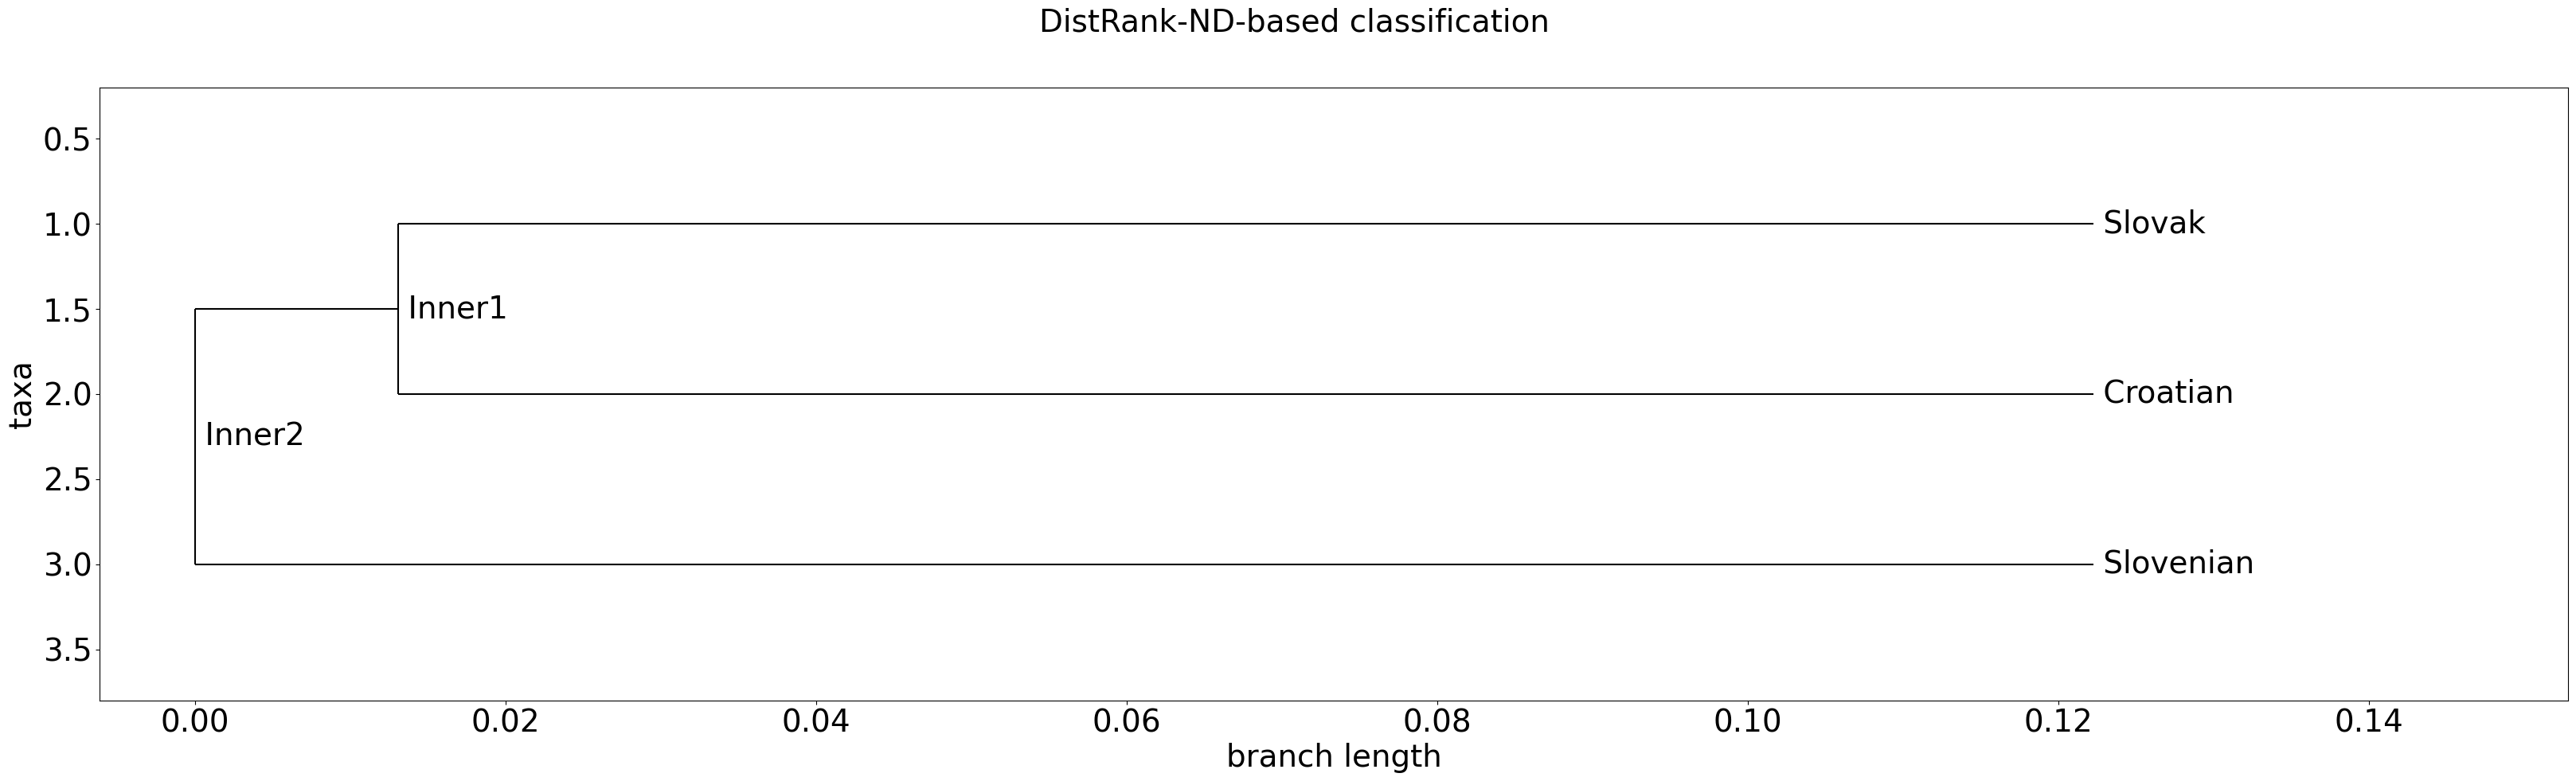

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
if (tree.clade.clades[0].name == OUTGROUP or tree.clade.clades[1].name == OUTGROUP):
  outgroup_clade = 0 if tree.clade.clades[0].name == OUTGROUP else 1
  ingroup_clade = 1 if tree.clade.clades[0].name == OUTGROUP else 0
  print("Outgroup detected correctly")
  print(f'Outer split distance is {tree.clade.clades[outgroup_clade].branch_length}')
  print(f'Inner split distance is {tree.clade.clades[ingroup_clade].branch_length}')
else:
  print("Outgroup detected incorrectly")
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':28}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'{METRICS}-based classification', fontsize=28)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_{METRICS}.png')
plt.show()

## DistRank, normalised by Levenshtein distance

In [ ]:
METRICS = 'LDN-normalised DistRank-ND'

In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(lects):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(dr_levs)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(lects))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.18819870105989445, 0], [0.1795585066238252, 0.16585246769587295, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(lects))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(name='Slovenian')
        Clade(name='Croatian')
        Clade(name='Slovak')


Outgroup detected incorrectly


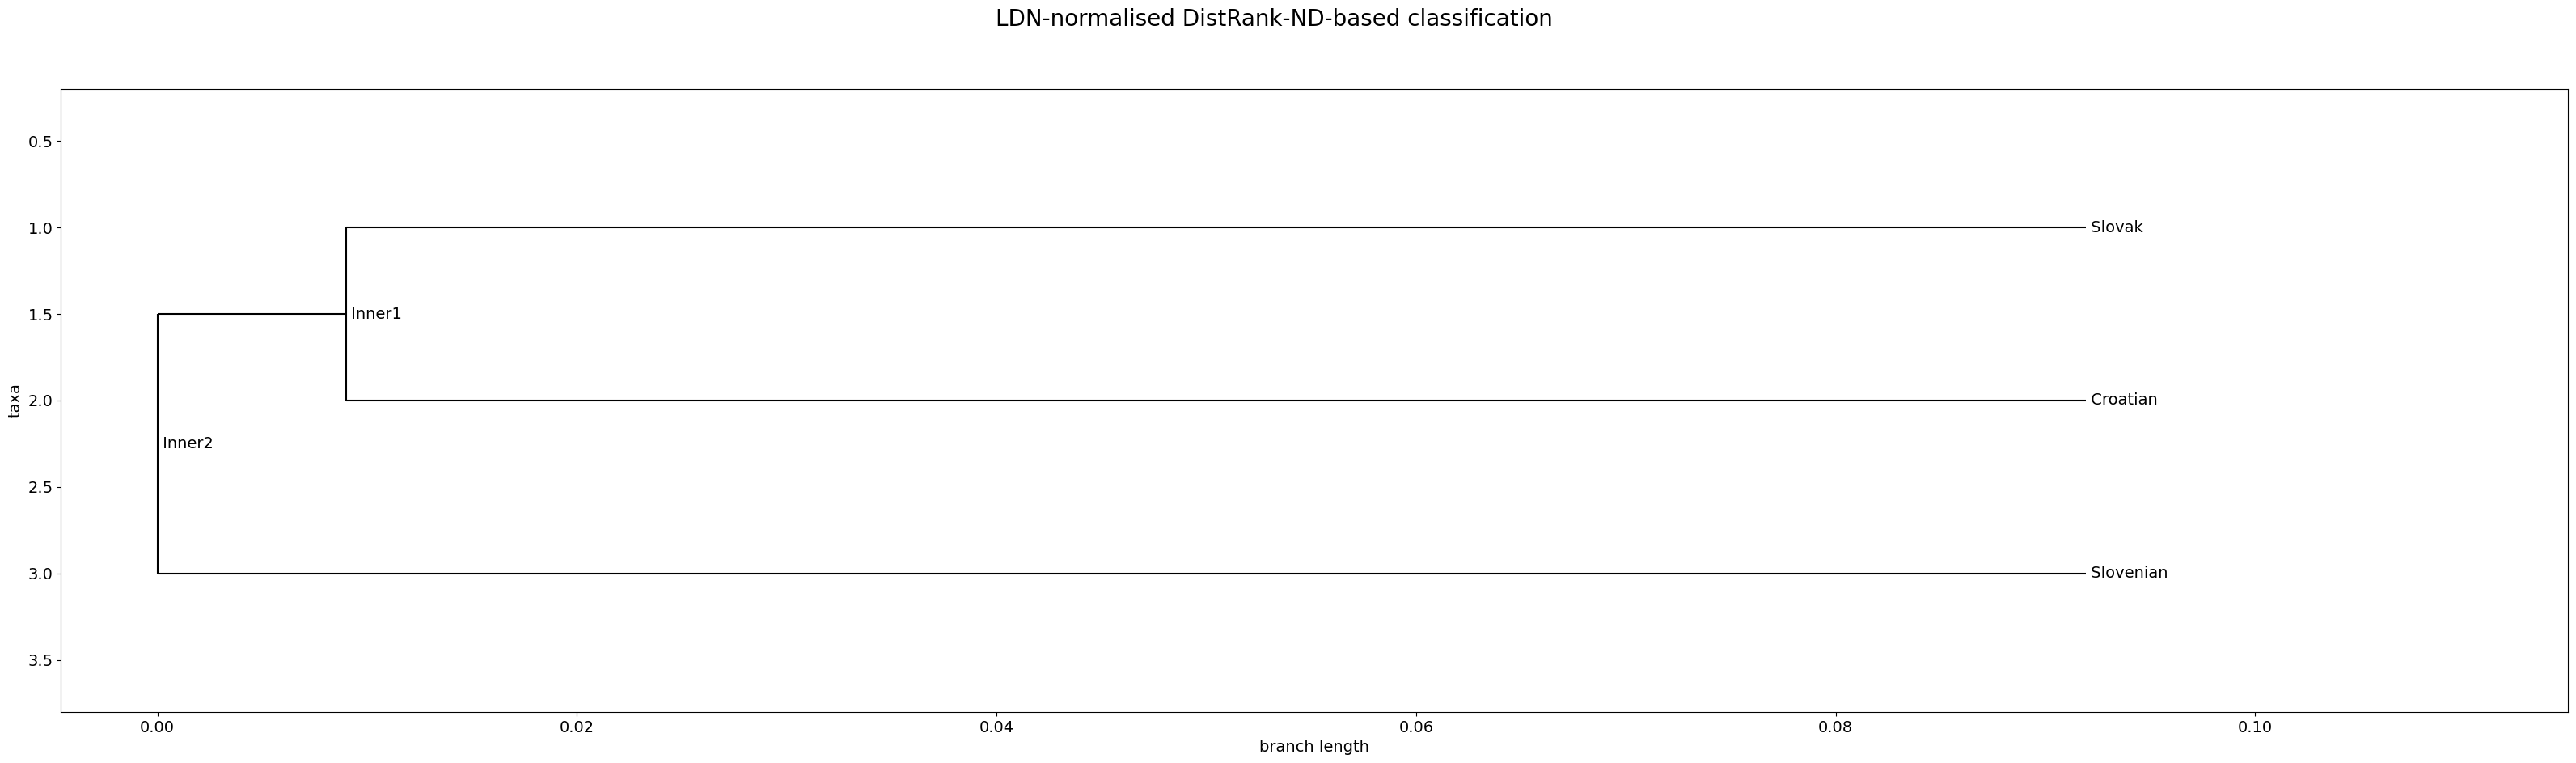

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
if (tree.clade.clades[0].name == OUTGROUP or tree.clade.clades[1].name == OUTGROUP):
  outgroup_clade = 0 if tree.clade.clades[0].name == OUTGROUP else 1
  ingroup_clade = 1 if tree.clade.clades[0].name == OUTGROUP else 0
  print("Outgroup detected correctly")
  print(f'Outer split distance is {tree.clade.clades[outgroup_clade].branch_length}')
  print(f'Inner split distance is {tree.clade.clades[ingroup_clade].branch_length}')
else:
  print("Outgroup detected incorrectly")
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'{METRICS}-based classification', fontsize=20)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_{METRICS}.png')
plt.show()

## DistRank, normalised by normalised Jaro-Winkler distance

In [ ]:
METRICS = 'NJWDN-normalised DistRank-ND'

In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(lects):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(dr_njws)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(lects))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.15407125790396894, 0], [0.15021514622030696, 0.14279522706638464, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(lects))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(name='Slovenian')
        Clade(name='Croatian')
        Clade(name='Slovak')


Outgroup detected incorrectly


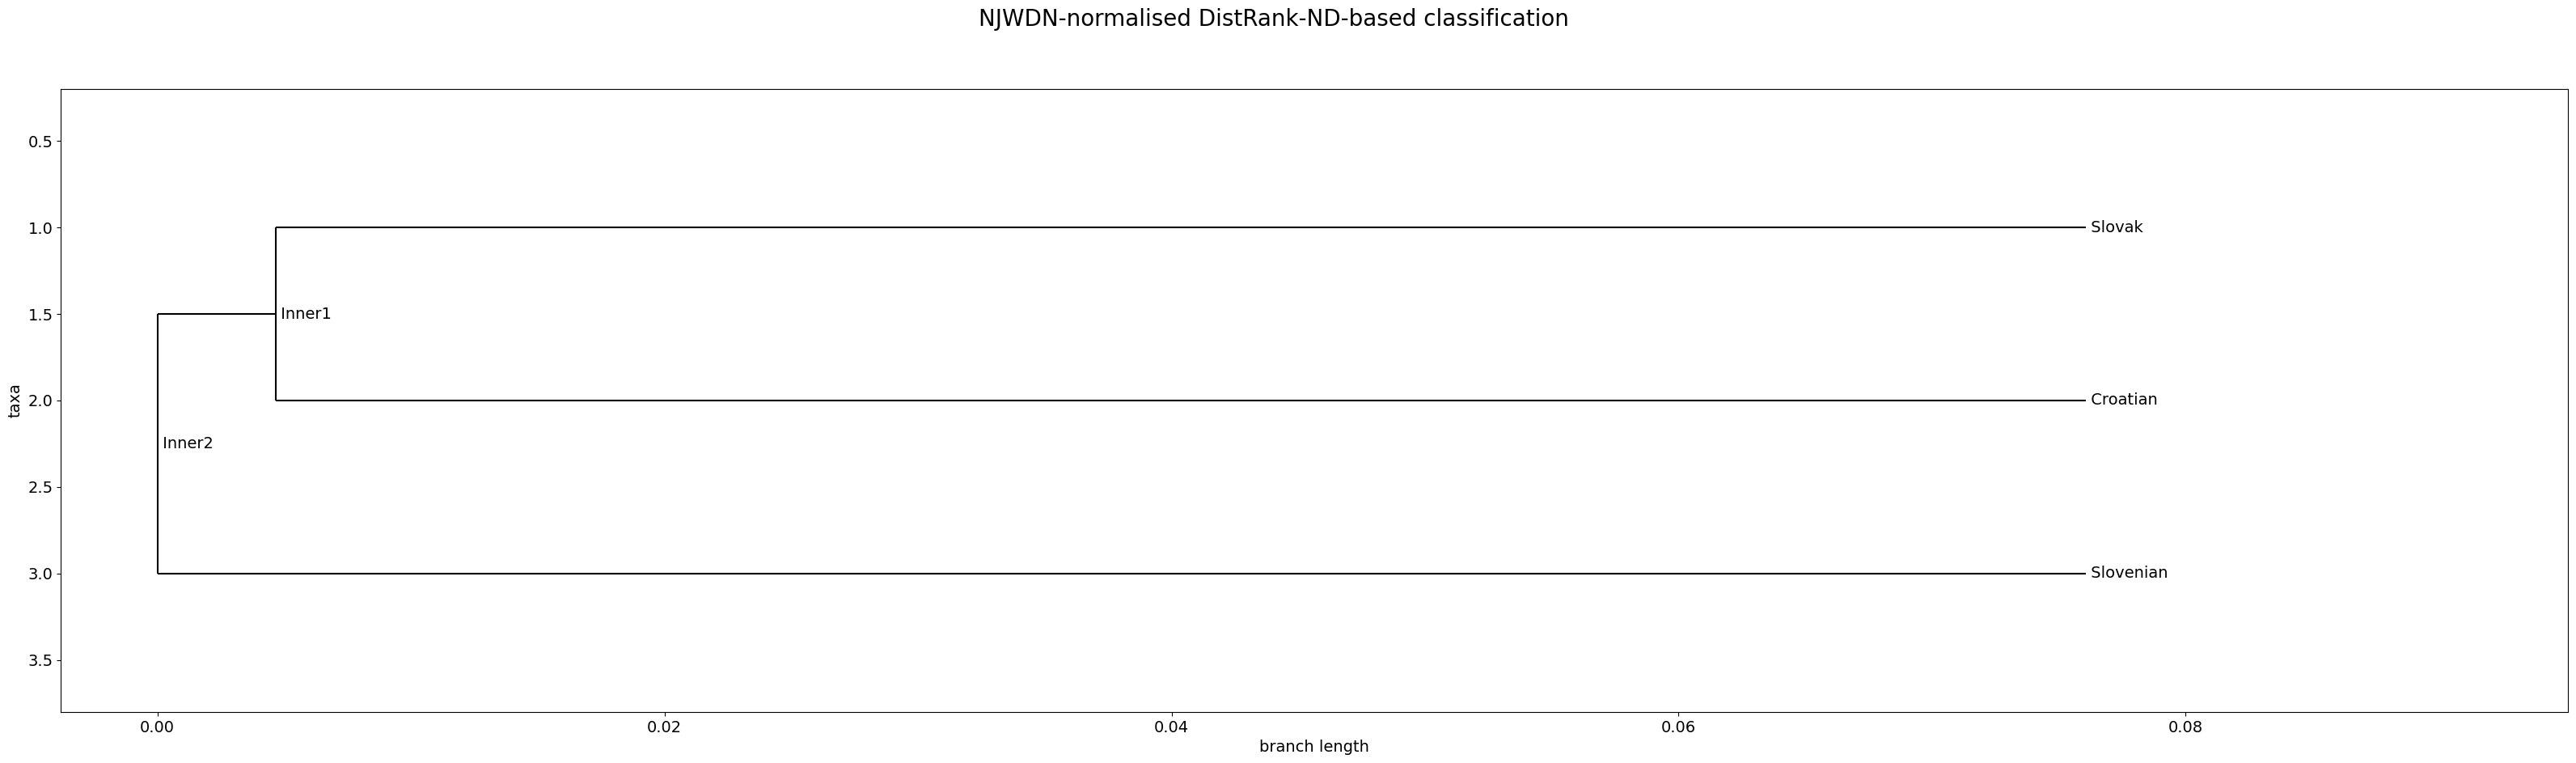

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
if (tree.clade.clades[0].name == OUTGROUP or tree.clade.clades[1].name == OUTGROUP):
  outgroup_clade = 0 if tree.clade.clades[0].name == OUTGROUP else 1
  ingroup_clade = 1 if tree.clade.clades[0].name == OUTGROUP else 0
  print("Outgroup detected correctly")
  print(f'Outer split distance is {tree.clade.clades[outgroup_clade].branch_length}')
  print(f'Inner split distance is {tree.clade.clades[ingroup_clade].branch_length}')
else:
  print("Outgroup detected incorrectly")
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'{METRICS}-based classification', fontsize=20)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_{METRICS}.png')
plt.show()

## Normalised DistRank and Levenshtein distance

In [ ]:
METRICS = 'LDN-DistRank-ND'

In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(lects):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(joined_levs)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(lects))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.7327711691578277, 0], [0.7740061388474382, 0.7659478326537836, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(lects))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(name='Slovenian')
        Clade(name='Croatian')
        Clade(name='Slovak')


Outgroup detected correctly
Outer split distance is 0.3204477685645879
Inner split distance is 0.03514344544835024


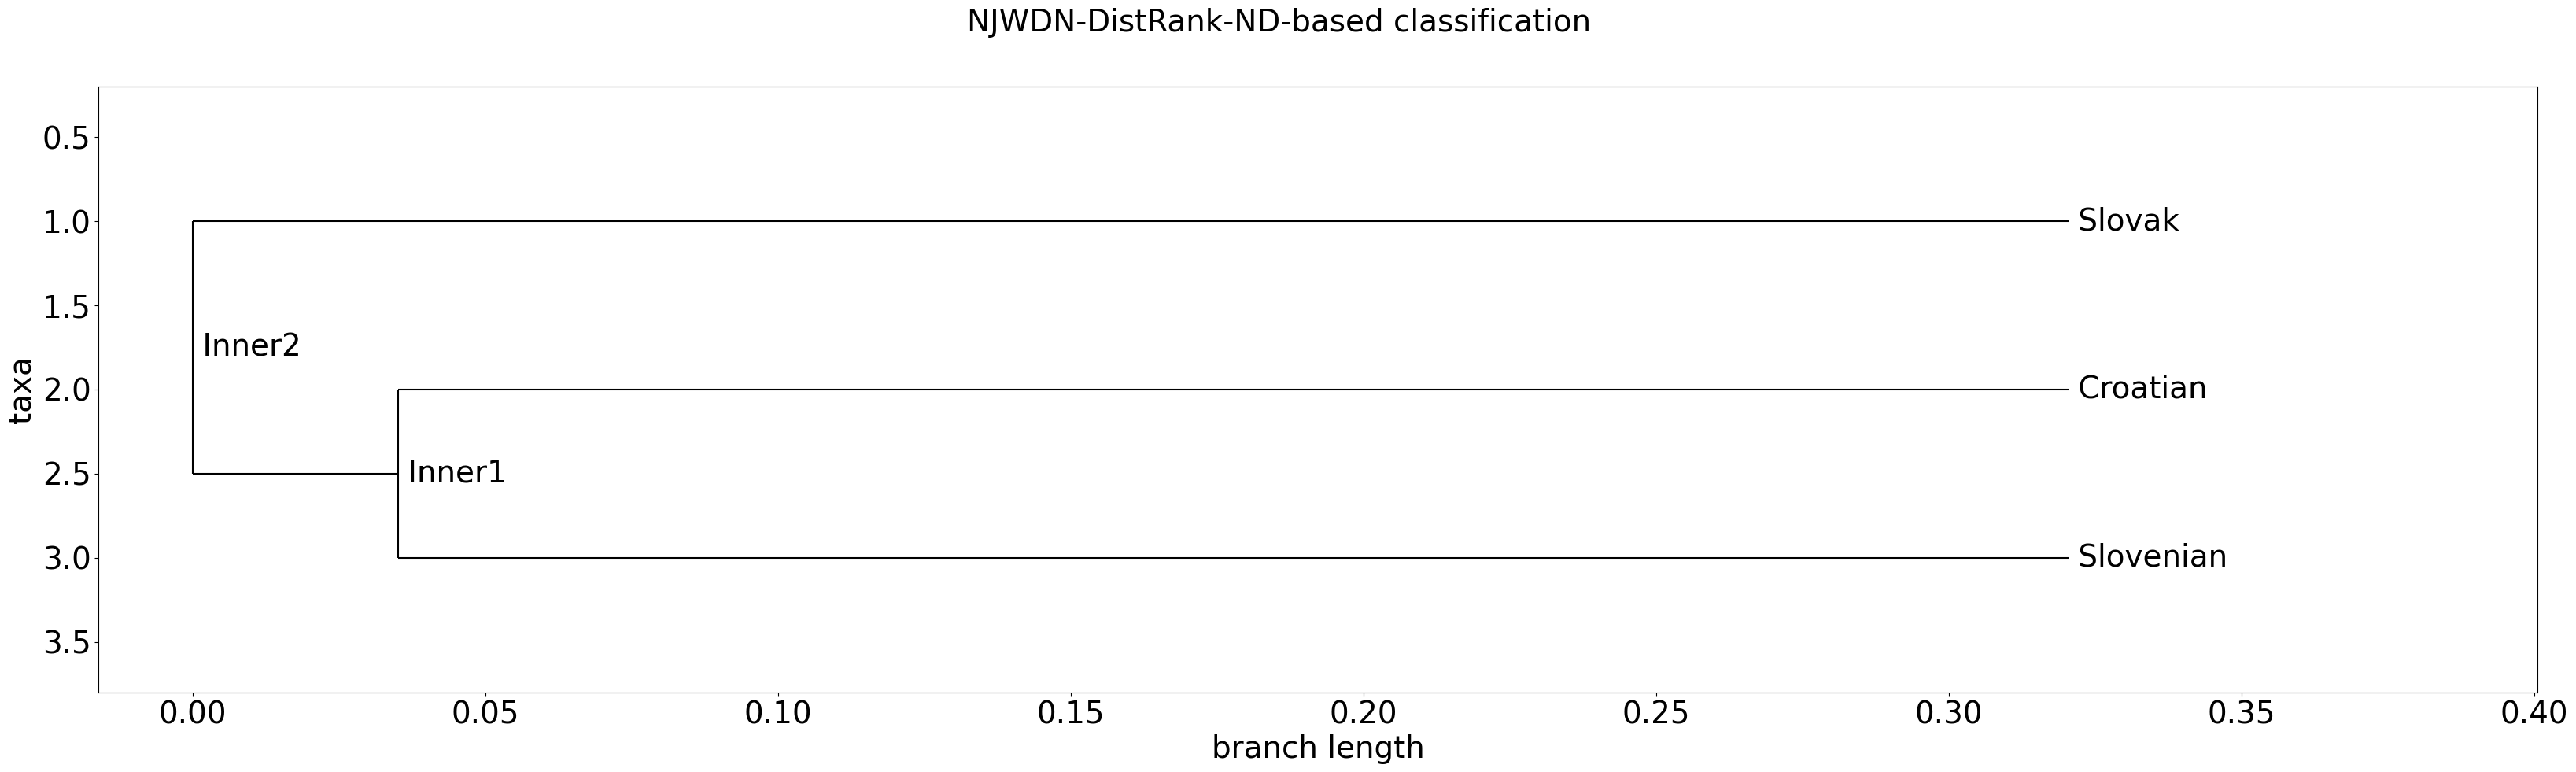

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
if (tree.clade.clades[0].name == OUTGROUP or tree.clade.clades[1].name == OUTGROUP):
  outgroup_clade = 0 if tree.clade.clades[0].name == OUTGROUP else 1
  ingroup_clade = 1 if tree.clade.clades[0].name == OUTGROUP else 0
  print("Outgroup detected correctly")
  print(f'Outer split distance is {tree.clade.clades[outgroup_clade].branch_length}')
  print(f'Inner split distance is {tree.clade.clades[ingroup_clade].branch_length}')
else:
  print("Outgroup detected incorrectly")
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':28}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'{METRICS}-based classification', fontsize=28)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_{METRICS}.png')
plt.show()

## Normalised DistRank and normalised Jaro-Winkler distance

In [ ]:
METRICS = 'NJWDN-DistRank-ND'

In [ ]:
# turning pairwise_distances in triangular matrix
final_matrix = []
# set size of matrix
for i in set(lects):
  final_matrix.append([])
# prepare results for yielding the next one
pairwise_distances_cycled = cycle(joined_njws)
# set column and row variables for filling each slot, starting with (0, 0)
current_column = 0
current_max_row = current_column
# while we did not went through all the lects
while current_column < len(list(set(lects))):
  # if we filled all the distances between this lect and others, add 0 distance between this lect and itself, and go to the next lect
  if (current_max_row == 0):
    final_matrix[current_column].append(0)
    current_column = current_column + 1
    current_max_row = current_column
    continue
  # otherwise, add distance between this lect and the next one
  final_matrix[current_column].append(next(pairwise_distances_cycled)[1])
  current_max_row = current_max_row - 1
print(final_matrix)

[[0], [0.5706086462324753, 0], [0.6365061431231795, 0.6452849311351719, 0]]


In [ ]:
# prepare triangular matrix: names of lects and distances between them
names = [str(i) for i in list(set(lects))]
lists_result = final_matrix
distance_matrix = _DistanceMatrix(names, lists_result)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)
print(tree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner1')
        Clade(name='Slovak')
        Clade(name='Croatian')
        Clade(name='Slovenian')


Outgroup detected correctly
Outer split distance is 0.3204477685645879
Inner split distance is 0.03514344544835024


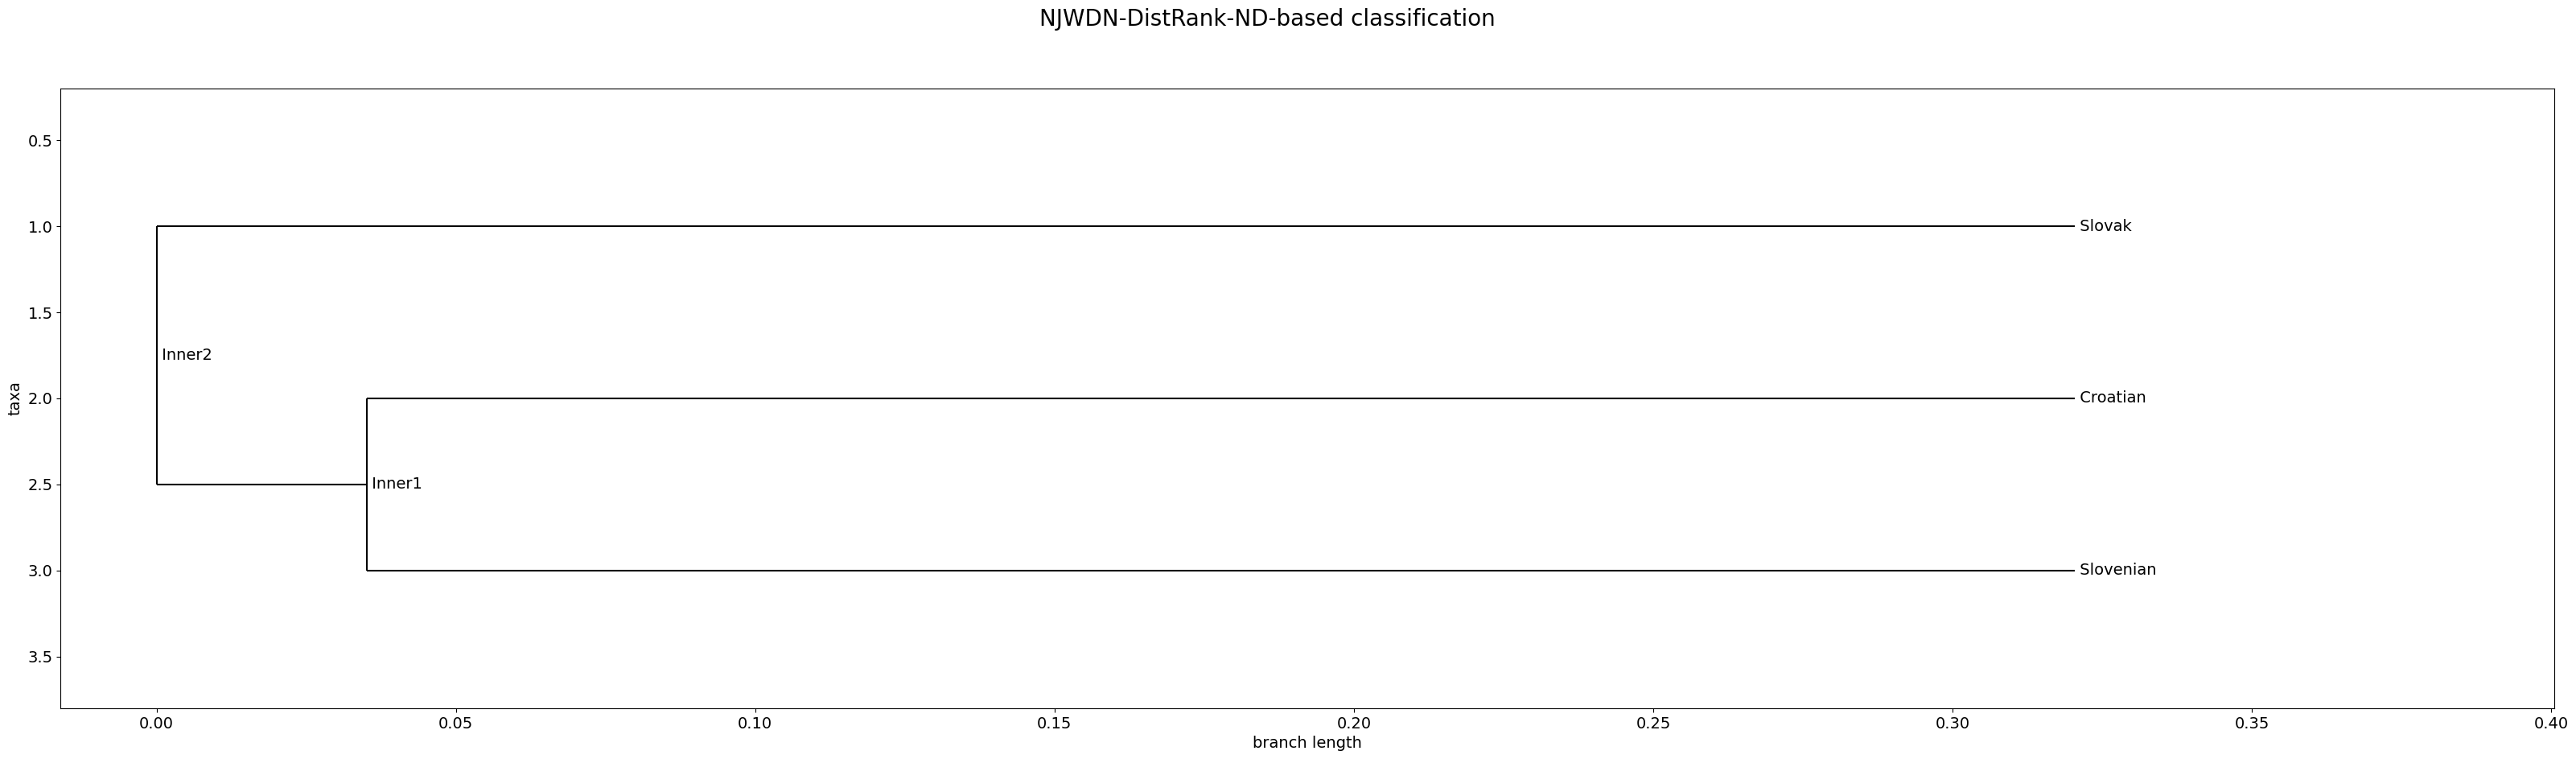

In [ ]:
# for visual presentation, we prefer using upgma to nj,
# as nj tends to assign negative values to some branches,
# upgma provides more comprehensible binary split
# and differences in rate of evolution
# for this East Slavic lects does not differ in a drastic manner
tree = constructor.upgma(distance_matrix)
if (tree.clade.clades[0].name == OUTGROUP or tree.clade.clades[1].name == OUTGROUP):
  outgroup_clade = 0 if tree.clade.clades[0].name == OUTGROUP else 1
  ingroup_clade = 1 if tree.clade.clades[0].name == OUTGROUP else 0
  print("Outgroup detected correctly")
  print(f'Outer split distance is {tree.clade.clades[outgroup_clade].branch_length}')
  print(f'Inner split distance is {tree.clade.clades[ingroup_clade].branch_length}')
else:
  print("Outgroup detected incorrectly")
%matplotlib inline
font = {'family':'DejaVu Sans', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(40, 10))
fig.suptitle(f'{METRICS}-based classification', fontsize=20)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)
plt.savefig(f'phylogeny_{METRICS}.png')
plt.show()